<a href="https://colab.research.google.com/github/LPValente/TensorFlow2.0/blob/main/TF2_0_Spam_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x # Only Colab.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [6]:
# Unfotunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-06-16 05:04:23--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2023-06-16 05:04:24 (11.2 MB/s) - ‘spam.csv’ saved [503663/503663]



In [7]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [8]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [9]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
# drop unnecessary columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [11]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# rename columns to something better
df.columns = ['labels', 'data']

In [13]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [15]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [16]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [17]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7255 unique tokens.


In [18]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [20]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor', data_test.shape)

Shape of data test tensor (1839, 189)


In [25]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V+1

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3,  activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [27]:
# Compile and fit
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

print("Training model...")
r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/5
117/117 [==============================] - 5s 32ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1019 - val_accuracy: 0.9875
Epoch 2/5
117/117 [==============================] - 3s 29ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.1047 - val_accuracy: 0.9880
Epoch 3/5
117/117 [==============================] - 3s 25ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1218 - val_accuracy: 0.9848
Epoch 4/5
117/117 [==============================] - 3s 25ms/step - loss: 8.9945e-04 - accuracy: 0.9995 - val_loss: 0.2697 - val_accuracy: 0.9728
Epoch 5/5
117/117 [==============================] - 3s 28ms/step - loss: 6.3505e-04 - accuracy: 0.9997 - val_loss: 0.1388 - val_accuracy: 0.9859


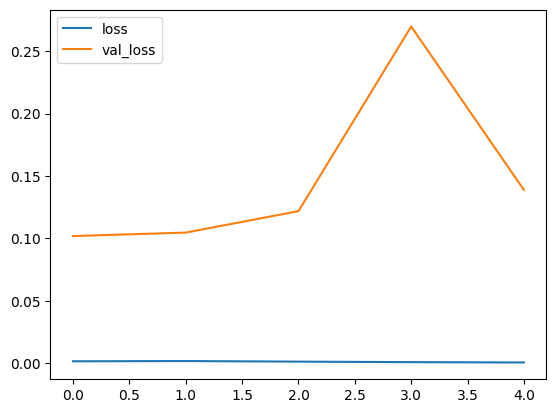

In [28]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

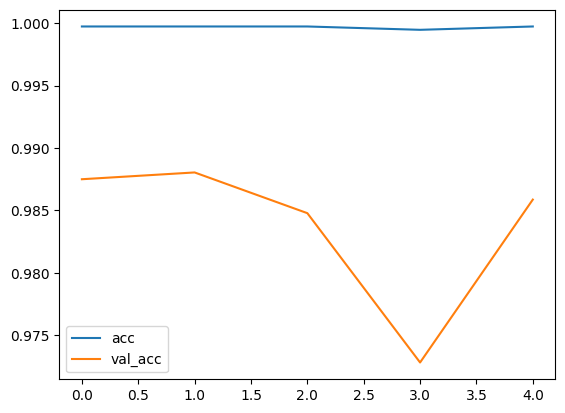

In [29]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()